In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct

In [4]:
### Utility functions

def second_largest_index(row):
    # Find the index of the second largest value in the row.
    sorted_indices = np.argsort(row)[::-1]
    return sorted_indices[1]

def dct2(block):
    # 2D Discrete Cosine Transform
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def load_zigzag_pattern(filename):
    # Load zigzag pattern from text file
    pattern = np.loadtxt(filename, dtype=int)
    return pattern

def zigzag_scan(matrix, pattern):
    # Apply zigzag scan using the provided pattern
    result = np.zeros(64)
    for i in range(8):
        for j in range(8):
            zigzag_index = pattern[i, j]
            result[zigzag_index] = matrix[i, j]
    return result

In [5]:
### Question 1

# Load the .mat file
mat_data = scipy.io.loadmat('TrainingSamplesDCT_8.mat')

# Extract the datasets (each row is a sample, each column is a feature)
background_data = mat_data['TrainsampleDCT_BG']
cheetah_data = mat_data['TrainsampleDCT_FG']

# Get the number of datapoints
background_count = background_data.shape[0]
cheetah_count = cheetah_data.shape[0]
total_count = background_count + cheetah_count

print(f"Number of background samples: {background_count}")
print(f"Number of cheetah samples: {cheetah_count}")
print(f"Feature dimension: {background_data.shape[1]}")

# Calculate prior probabilities
prior_cheetah = cheetah_count / total_count
prior_background = background_count / total_count

print(f"Prior probability of cheetah: {prior_cheetah:.4f}")
print(f"Prior probability of background: {prior_background:.4f}")

Number of background samples: 1053
Number of cheetah samples: 250
Feature dimension: 64
Prior probability of cheetah: 0.1919
Prior probability of background: 0.8081


In [6]:
# Question 2

# Foreground (Cheetah) distribution
cheetah_indices = []
for row in range(cheetah_data.shape[0]):
    second_max_idx = second_largest_index(cheetah_data[row, :])
    cheetah_indices.append(second_max_idx)

# Create histogram with 64 bins (indices 0-63)
counts_cheetah, _ = np.histogram(cheetah_indices, bins=np.arange(-0.5, 64.5, 1))
prob_cheetah = counts_cheetah / counts_cheetah.sum()

# Plot foreground histogram
plt.figure(figsize=(10, 6))
plt.bar(range(64), prob_cheetah, width=1.0, edgecolor='black', alpha=0.7)
plt.xlabel('Feature Index (0-63)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Cheetah (Foreground) Probability Distribution', fontsize=14)
plt.xlim(-0.5, 63.5)
plt.grid(axis='y', alpha=0.3)
plt.savefig('foreground_hist.jpg', dpi=150, bbox_inches='tight')
plt.close()

# Background (Grass) distribution
background_indices = []
for row in range(background_data.shape[0]):
    second_max_idx = second_largest_index(background_data[row, :])
    background_indices.append(second_max_idx)

# Create histogram with 64 bins (indices 0-63)
counts_background, _ = np.histogram(background_indices, bins=np.arange(-0.5, 64.5, 1))
prob_background = counts_background / counts_background.sum()

# Plot background histogram
plt.figure(figsize=(10, 6))
plt.bar(range(64), prob_background, width=1.0, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Feature Index (0-63)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Background (Grass) Probability Distribution', fontsize=14)
plt.xlim(-0.5, 63.5)
plt.grid(axis='y', alpha=0.3)
plt.savefig('background_hist.jpg', dpi=150, bbox_inches='tight')
plt.close()


Cheetah probability distribution computed: sum = 1.0000
Background probability distribution computed: sum = 1.0000


Zigzag pattern loaded successfully
Original image size: 255 x 270
Padded image size: 263 x 278
Processing 8x8 blocks...
Feature extraction complete. Output shape: (255, 270)
Performing Bayesian classification...
Classification complete.
Number of cheetah pixels predicted: 7493
Number of background pixels predicted: 61357


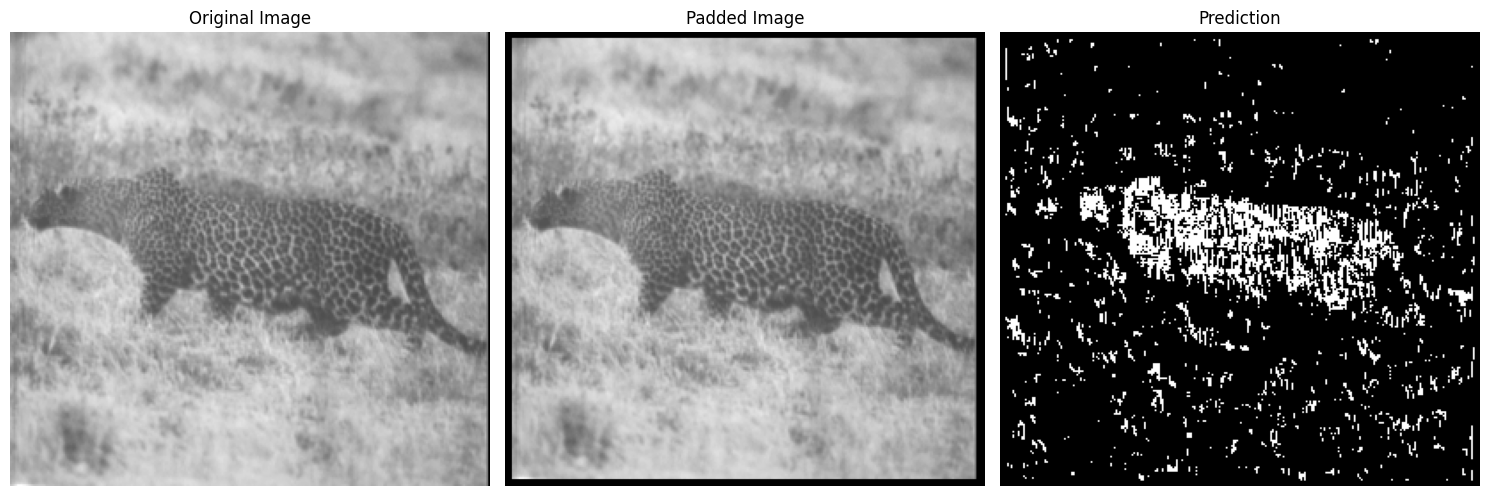

In [7]:
### Question 3

zigzag_pattern = load_zigzag_pattern('Zig-Zag Pattern.txt')
print("Zigzag pattern loaded successfully")
img = np.array(Image.open('cheetah.bmp').convert('L'), dtype=float) / 255.0
original_height, original_width = img.shape
print(f"Original image size: {original_height} x {original_width}")

# Add uniform padding of 4 pixels on all sides
# This allows us to extract 8x8 blocks starting from position (0,0) in the padded image
padding = 4
img_padded = np.pad(img, ((padding, padding), (padding, padding)),
                    mode='constant', constant_values=0)
padded_height, padded_width = img_padded.shape
print(f"Padded image size: {padded_height} x {padded_width}")

# The output will have the same dimensions as the original image
# Each pixel (i,j) in the output corresponds to the 8x8 block centered around
# pixel (i,j) in the original image
output_height = original_height
output_width = original_width

# Initialize array to store the feature index for each block
feature_indices = np.zeros((output_height, output_width), dtype=int)

# Process each 8x8 block
print("Processing 8x8 blocks...")
for i in range(output_height):
    for j in range(output_width):
        # Extract 8x8 block from padded image
        # Block starts at (i, j) in padded coordinates
        block = img_padded[i:i+8, j:j+8]

        # Apply 2D DCT and take absolute values
        dct_block = np.abs(dct2(block))

        # Apply zigzag scan
        zigzag_vector = zigzag_scan(dct_block, zigzag_pattern)

        # Find index of second largest coefficient (0-indexed)
        feature_idx = second_largest_index(zigzag_vector)
        feature_indices[i, j] = feature_idx

print(f"Feature extraction complete. Output shape: {feature_indices.shape}")

# Bayesian classification
print("Performing Bayesian classification...")
prediction = np.zeros((output_height, output_width), dtype=int)

for i in range(output_height):
    for j in range(output_width):
        feature_idx = feature_indices[i, j]

        # Calculate posterior probabilities (up to normalization constant)
        posterior_cheetah = prob_cheetah[feature_idx] * prior_cheetah
        posterior_background = prob_background[feature_idx] * prior_background

        # Classify based on maximum posterior probability
        if posterior_cheetah >= posterior_background:
            prediction[i, j] = 1  # Cheetah
        else:
            prediction[i, j] = 0  # Background

print(f"Classification complete.")
print(f"Number of cheetah pixels predicted: {np.sum(prediction)}")
print(f"Number of background pixels predicted: {prediction.size - np.sum(prediction)}")

# Save prediction
plt.figure(figsize=(10, 8))
plt.imshow(prediction, cmap='gray')
plt.axis('off')
plt.title('Prediction (White=Cheetah, Black=Background)', fontsize=14)
plt.savefig('prediction.jpg', dpi=150, bbox_inches='tight', pad_inches=0)
plt.close()

# Save as binary image
prediction_img = Image.fromarray((prediction * 255).astype(np.uint8))
prediction_img.save('prediction_binary.jpg')

# Display comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_padded, cmap='gray')
plt.title('Padded Image', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.savefig('comparison.jpg', dpi=150, bbox_inches='tight')
plt.show()

Ground Truth Statistics:
  Total cheetah pixels: 13209 (19.19%)
  Total background pixels: 55641 (80.81%)

Classification Errors:
  False Negatives (missed cheetah): 8672
  False Positives (false alarms): 2956
  Total misclassified: 11628

Error Rates:
  False Negative Rate: 0.656522 (65.6522%)
  False Positive Rate: 0.053126 (5.3126%)

Probability of Error (Weighted by Priors):
  P(error | cheetah) × P(cheetah) = 0.125964
  P(error | background) × P(background) = 0.042933
  Total Probability of Error = 0.168897



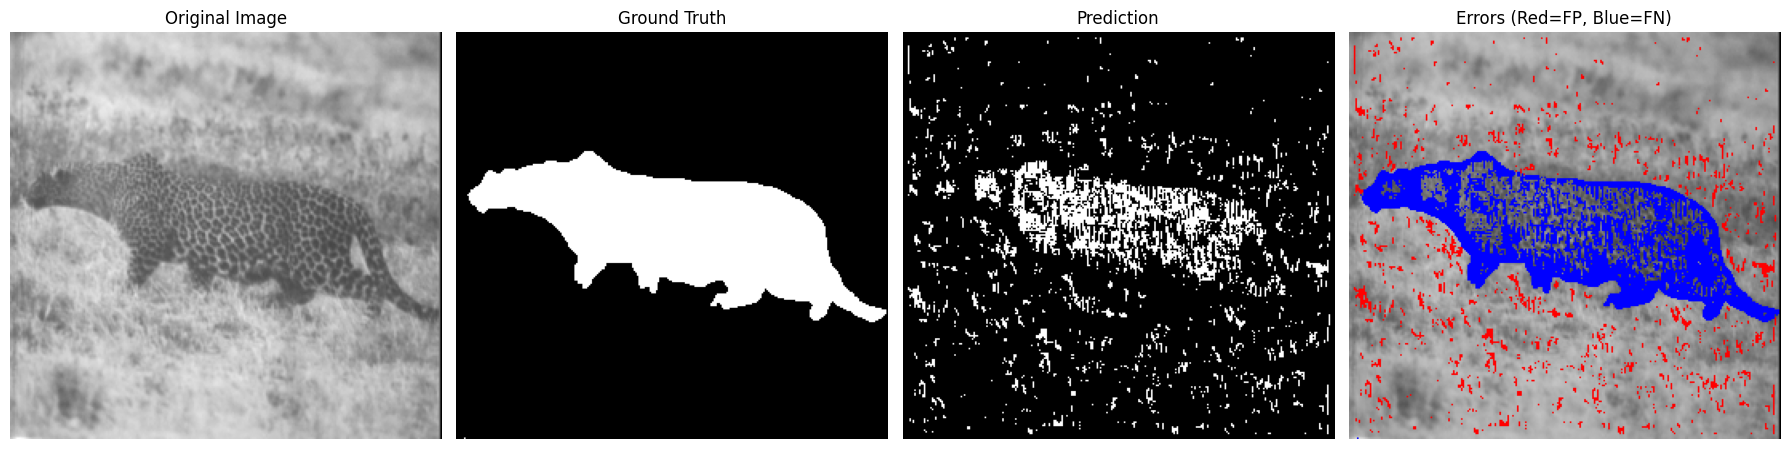

In [8]:
### Question 4

# Load ground truth mask
ground_truth = np.array(Image.open('cheetah_mask.bmp').convert('L'), dtype=float) / 255.0
ground_truth = (ground_truth > 0.5).astype(int)  # Binarize

# Verify dimensions match
assert ground_truth.shape == prediction.shape, \
    f"Dimension mismatch: ground_truth {ground_truth.shape} vs prediction {prediction.shape}"

height, width = ground_truth.shape

# Initialize counters
false_negatives = 0  # Cheetah classified as background
false_positives = 0  # Background classified as cheetah
total_cheetah = 0
total_background = 0

# Compare prediction with ground truth
for i in range(height):
    for j in range(width):
        if ground_truth[i, j] == 1:  # True cheetah
            total_cheetah += 1
            if prediction[i, j] == 0:  # Predicted as background
                false_negatives += 1
        else:  # True background
            total_background += 1
            if prediction[i, j] == 1:  # Predicted as cheetah
                false_positives += 1

# Calculate error rates
false_negative_rate = false_negatives / total_cheetah if total_cheetah > 0 else 0
false_positive_rate = false_positives / total_background if total_background > 0 else 0

# Calculate probability of error (Bayes error weighted by priors)
error_cheetah = false_negative_rate * prior_cheetah
error_background = false_positive_rate * prior_background
total_error = error_cheetah + error_background

# Print results
print(f"Ground Truth Statistics:")
print(f"  Total cheetah pixels: {total_cheetah} ({100*total_cheetah/(height*width):.2f}%)")
print(f"  Total background pixels: {total_background} ({100*total_background/(height*width):.2f}%)")
print()
print(f"Classification Errors:")
print(f"  False Negatives (missed cheetah): {false_negatives}")
print(f"  False Positives (false alarms): {false_positives}")
print(f"  Total misclassified: {false_negatives + false_positives}")
print()
print(f"Error Rates:")
print(f"  False Negative Rate: {false_negative_rate:.6f} ({100*false_negative_rate:.4f}%)")
print(f"  False Positive Rate: {false_positive_rate:.6f} ({100*false_positive_rate:.4f}%)")
print()
print(f"Probability of Error (Weighted by Priors):")
print(f"  P(error | cheetah) × P(cheetah) = {error_cheetah:.6f}")
print(f"  P(error | background) × P(background) = {error_background:.6f}")
print(f"  Total Probability of Error = {total_error:.6f}")
print()

# Visualize results
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image', fontsize=12)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth', fontsize=12)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction', fontsize=12)
plt.axis('off')

# Show errors
error_map = np.zeros((height, width, 3))
error_map[:, :, 0] = img  # Red channel
error_map[:, :, 1] = img  # Green channel
error_map[:, :, 2] = img  # Blue channel

# False positives in red
for i in range(height):
    for j in range(width):
        if ground_truth[i, j] == 0 and prediction[i, j] == 1:
            error_map[i, j] = [1, 0, 0]  # Red
        elif ground_truth[i, j] == 1 and prediction[i, j] == 0:
            error_map[i, j] = [0, 0, 1]  # Blue

plt.subplot(1, 4, 4)
plt.imshow(error_map)
plt.title('Errors (Red=FP, Blue=FN)', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.savefig('error_analysis.jpg', dpi=150, bbox_inches='tight')
plt.show()